## Advanced Data Synthesis: 
## Speed, Efficiency, and Replicability with GANs and Copulas

### Importing Libraries and Loading the Data
Let's start with the Gaussian copula approach for generating synthetic observations for the insurance dataset<br>
using different copulas for each group, defined by the sex, smoker, and region fields.

In [1]:
import pandas as pd
from scipy.stats import norm
import numpy as np

# Load the dataset
url = "https://raw.githubusercontent.com/VincentGranville/Main/main/insurance.csv"
data = pd.read_csv(url)
print(data.head(10))

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
5   31  female  25.740         0     no  southeast   3756.62160
6   46  female  33.440         1     no  southeast   8240.58960
7   37  female  27.740         3     no  northwest   7281.50560
8   37    male  29.830         2     no  northeast   6406.41070
9   60  female  25.840         0     no  northwest  28923.13692


### Defining groups and Extracting real data
We will define the groups based on 'sex', 'smoker' and 'region' and then extract the real data corresponding to each of these groups.

In [2]:
# Initialize dictionaries to hold group counts and real data
groupCount = {}
groupReal = {}

# Iterate over the dataset to categorize observations by group
for k in range(len(data)):
    obs = data.iloc[k]
    group = f"{obs['sex']}\t{obs['smoker']}\t{obs['region']}"
    
    if group in groupCount:
        cnt = groupCount[group]
        groupReal[(group, cnt)] = (obs['age'], obs['bmi'], obs['children'], obs['charges'])
        groupCount[group] += 1
    else:
        groupReal[(group, 0)] = (obs['age'], obs['bmi'], obs['children'], obs['charges'])
        groupCount[group] = 1

# Print the counts and examples of data for a specific group
for group in groupCount:
    print(group, groupCount[group])

print(groupReal[("female\tyes\tsouthwest", 0)])
print(groupReal[("female\tyes\tsouthwest", 1)])
print(groupReal[("female\tyes\tsouthwest", 2)])
print(groupReal[("female\tyes\tsouthwest", 3)])
print(groupReal[("female\tyes\tsouthwest", 20)])

female	yes	southwest 21
male	no	southeast 134
male	no	northwest 132
female	no	southeast 139
female	no	northwest 135
male	no	northeast 125
female	yes	southeast 36
male	no	southwest 126
male	yes	southeast 55
female	no	northeast 132
male	yes	southwest 37
female	no	southwest 141
female	yes	northeast 29
male	yes	northeast 38
male	yes	northwest 29
female	yes	northwest 29
(19, 27.9, 0, 16884.924)
(37, 34.8, 2, 39836.519)
(64, 31.3, 2, 47291.055)
(19, 28.3, 0, 17081.08)
(19, 34.7, 2, 36397.576)


### Creating tables for each group (real data)

In [3]:
def create_table(group, groupCount, groupReal):
    nobs = groupCount[group]
    age = []
    bmi = []
    children = []
    charges = []
    
    for cnt in range(nobs):
        features = groupReal[(group, cnt)]
        age.append(float(features[0]))
        bmi.append(float(features[1]))
        children.append(float(features[2]))
        charges.append(float(features[3]))
        
    real = np.stack((age, bmi, children, charges), axis=0)
    return real

### Synthesizing data using Gaussian Copula

In [4]:
def gaussian_to_synth(real, gfg, group, nobs_synth, groupSynth):
    age = real[0, :]
    bmi = real[1, :]
    children = real[2, :]
    charges = real[3, :]
    
    g_age = gfg[:, 0]
    g_bmi = gfg[:, 1]
    g_children = gfg[:, 2]
    g_charges = gfg[:, 3]
    
    for k in range(nobs_synth):
        u_age = norm.cdf(g_age[k])
        u_bmi = norm.cdf(g_bmi[k])
        u_children = norm.cdf(g_children[k])
        u_charges = norm.cdf(g_charges[k])
        
        s_age = np.quantile(age, u_age)
        s_bmi = np.quantile(bmi, u_bmi)
        s_children = np.quantile(children, u_children)
        s_charges = np.quantile(charges, u_charges)
        
        groupSynth[(group, k)] = [s_age, s_bmi, s_children, s_charges]
    return

In [5]:
# Seed for reproducibility
seed = 453
np.random.seed(seed)

# Initialize the dictionary to hold synthetic data
groupSynth = {}

# Generate synthetic data for each group
for group in groupCount:
    real = create_table(group, groupCount, groupReal)
    n_var = real.shape[0]
    zero = np.zeros(n_var)
    corr = np.corrcoef(real)  # Correlation matrix for Gaussian copula for this group
    nobs_synth = groupCount[group]  # Number of synthetic observations to create for this group
    gfg = np.random.multivariate_normal(zero, corr, nobs_synth)
    gaussian_to_synth(real, gfg, group, nobs_synth, groupSynth)

# Print synthesized data for the sample group: female\tyes\southwest
for group, k in groupSynth:
    obs = groupSynth[(group, k)]
    if group == "female\tyes\tsouthwest":
        print(f"{obs[0]:6.2f} {obs[1]:7.2f} {obs[2]:6.2f} {obs[3]:10.2f}")

 29.24   31.05   2.00   31812.65
 37.79   27.89   2.00   27595.47
 36.72   26.53   1.00   18972.35
 19.25   21.83   2.00   16925.74
 19.00   30.78   0.00   17545.09
 46.02   30.97   2.00   26974.52
 19.00   27.18   0.00   17380.77
 29.27   26.80   0.00   18936.03
 48.07   31.40   1.00   40524.87
 19.85   21.70   1.18   14858.06
 19.00   28.15   1.25   17297.46
 36.06   31.56   0.00   34401.89
 19.00   35.93   0.00   45531.59
 46.72   33.87   2.00   42533.74
 45.13   33.82   0.00   47295.20
 63.04   29.14   0.98   47258.66
 38.82   34.66   0.00   47673.08
 20.20   22.19   0.00   16970.50
 26.66   22.27   2.00   19484.48
 23.09   27.62   0.39   18924.28
 39.16   31.01   2.00   34694.34


Level 0: delta: 0.0926 mu: 1.1612 std: 1.2698 p: 0.3000 a: -1.5000
Level 1: delta: 0.0353 mu: 1.0640 std: 1.2219 p: 0.3000 a: -1.3500
Level 2: delta: 0.0032 mu: 1.0962 std: 1.2020 p: 0.2700 a: -1.6500

Sample stats: mean: 1.094 std: 1.202 max: 10.000


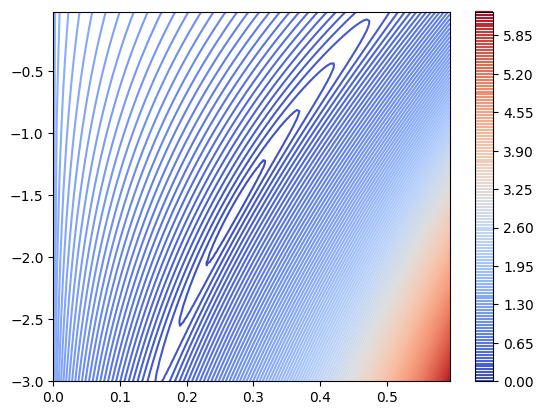

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

#--- Compute mean and stdev of ZetaGeom[p, a]
def ZetaGeom(p, a):
    C = sum([p**k / (k+1)**a for k in range(200)])
    mu = sum([k * p**k / (k+1)**a for k in range(200)]) / C
    m2 = sum([k*k * p**k / (k+1)**a for k in range(200)]) / C
    var = m2 - mu**2
    return mu, np.sqrt(var)

#--- Optimized grid search to find optimal p and a
def grid_search(grid_range):
    p_min, p_max = grid_range[0]
    a_min, a_max = grid_range[1]
    p_step = (p_max - p_min) / 10
    a_step = (a_max - a_min) / 10
    min_delta = float('inf')
    
    for p in np.arange(p_min, p_max, p_step):
        for a in np.arange(a_min, a_max, a_step):
            mu, std = ZetaGeom(p, a)
            delta = np.sqrt((mu - target_mu)**2 + (std - target_std)**2)
            if delta < min_delta:
                p_best, a_best, mu_best, std_best = p, a, mu, std
                min_delta = delta
                
    return p_best, a_best, mu_best, std_best, min_delta

#--- Target mean and standard deviation from real data
target_mu = 1.095
target_std = 1.205
p, a = 0.5, 0.0
step_p, step_a = 0.4, 3.0

#--- Iterative optimization loop
for level in range(3):
    step_p /= 2
    step_a /= 2
    p_min, p_max = max(0, p - step_p), p + step_p
    a_min, a_max = a - step_a, a + step_a
    grid_range = [(p_min, p_max), (a_min, a_max)]
    p, a, mu, std, min_delta = grid_search(grid_range)
    print(f"Level {level}: delta: {min_delta:.4f} mu: {mu:.4f} std: {std:.4f} p: {p:.4f} a: {a:.4f}")

#--- Sampling from ZetaGeom[p, a]
def CDF(p, a):
    C = sum([p**k / (k+1)**a for k in range(100)])
    return [sum([p**j / (j+1)**a for j in range(k+1)]) / C for k in range(100)]

def sample_from_CDF(p, a):
    u = np.random.uniform(0, 1)
    arr_CDF = CDF(p, a)
    return next(k for k in range(100) if u < arr_CDF[k])

#--- Generate samples with optimized p and a
nobs = 50000
np.random.seed(500)
samples = [sample_from_CDF(p, a) for _ in range(nobs)]
print(f"\nSample stats: mean: {np.mean(samples):.3f} std: {np.std(samples):.3f} max: {max(samples):.3f}")

#--- Plot loss function
xa, ya = np.meshgrid(np.arange(0.0, 0.6, 0.005), np.arange(-3.0, 0.0, 0.025))
za = np.array([[np.sqrt((ZetaGeom(p, a)[0] - target_mu)**2 + (ZetaGeom(p, a)[1] - target_std)**2) 
                for p in np.arange(0.0, 0.6, 0.005)] for a in np.arange(-3.0, 0.0, 0.025)])

plt.contour(xa, ya, za, levels=150, cmap=cm.coolwarm)
plt.colorbar()
plt.show()
